In [1]:
from pyabc import History
from pyabc.visualization import plot_kde_matrix, kde_1d
import pyabc.visualization
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import random

from tools.DataSimulator import simulate, simulate_all_dates

/home/jminucci/anaconda3/envs/pyabc/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/jminucci/anaconda3/envs/pyabc/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Load the study data

In [2]:
# Read the study data on adults into a dictionary
study_data_path = os.path.abspath('data/data_adults.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
    
# Read the full data set for plots/comparison with model output
study_data_all_path = os.path.abspath('data/data_all.csv')
reader = csv.reader(open(study_data_all_path, 'r'))
study_data_all = {}
for row in reader:
   k, v = row
   study_data_all[k] = float(v)

In [31]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0, 100), 
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0,100),
              AILarvaSlope=(1, 9))

### Load the completed AMC-SMC run

In [5]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           #os.path.join(database_dir, "run_12_20.db"))
           os.path.join(database_dir, "run_3_11.db"))
history = History(db_path)
history.id = 1

#also load the control only run for comparison
db_path_ctrl = ("sqlite:///" +
           os.path.join(database_dir, "ctrl_only_12_14.db"))
history_ctrl = History(db_path_ctrl)
history_ctrl.id = 1

### Show posterior for last generation

In [32]:
t = history.max_t
df, w = history.get_distribution(m=0, t=t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000

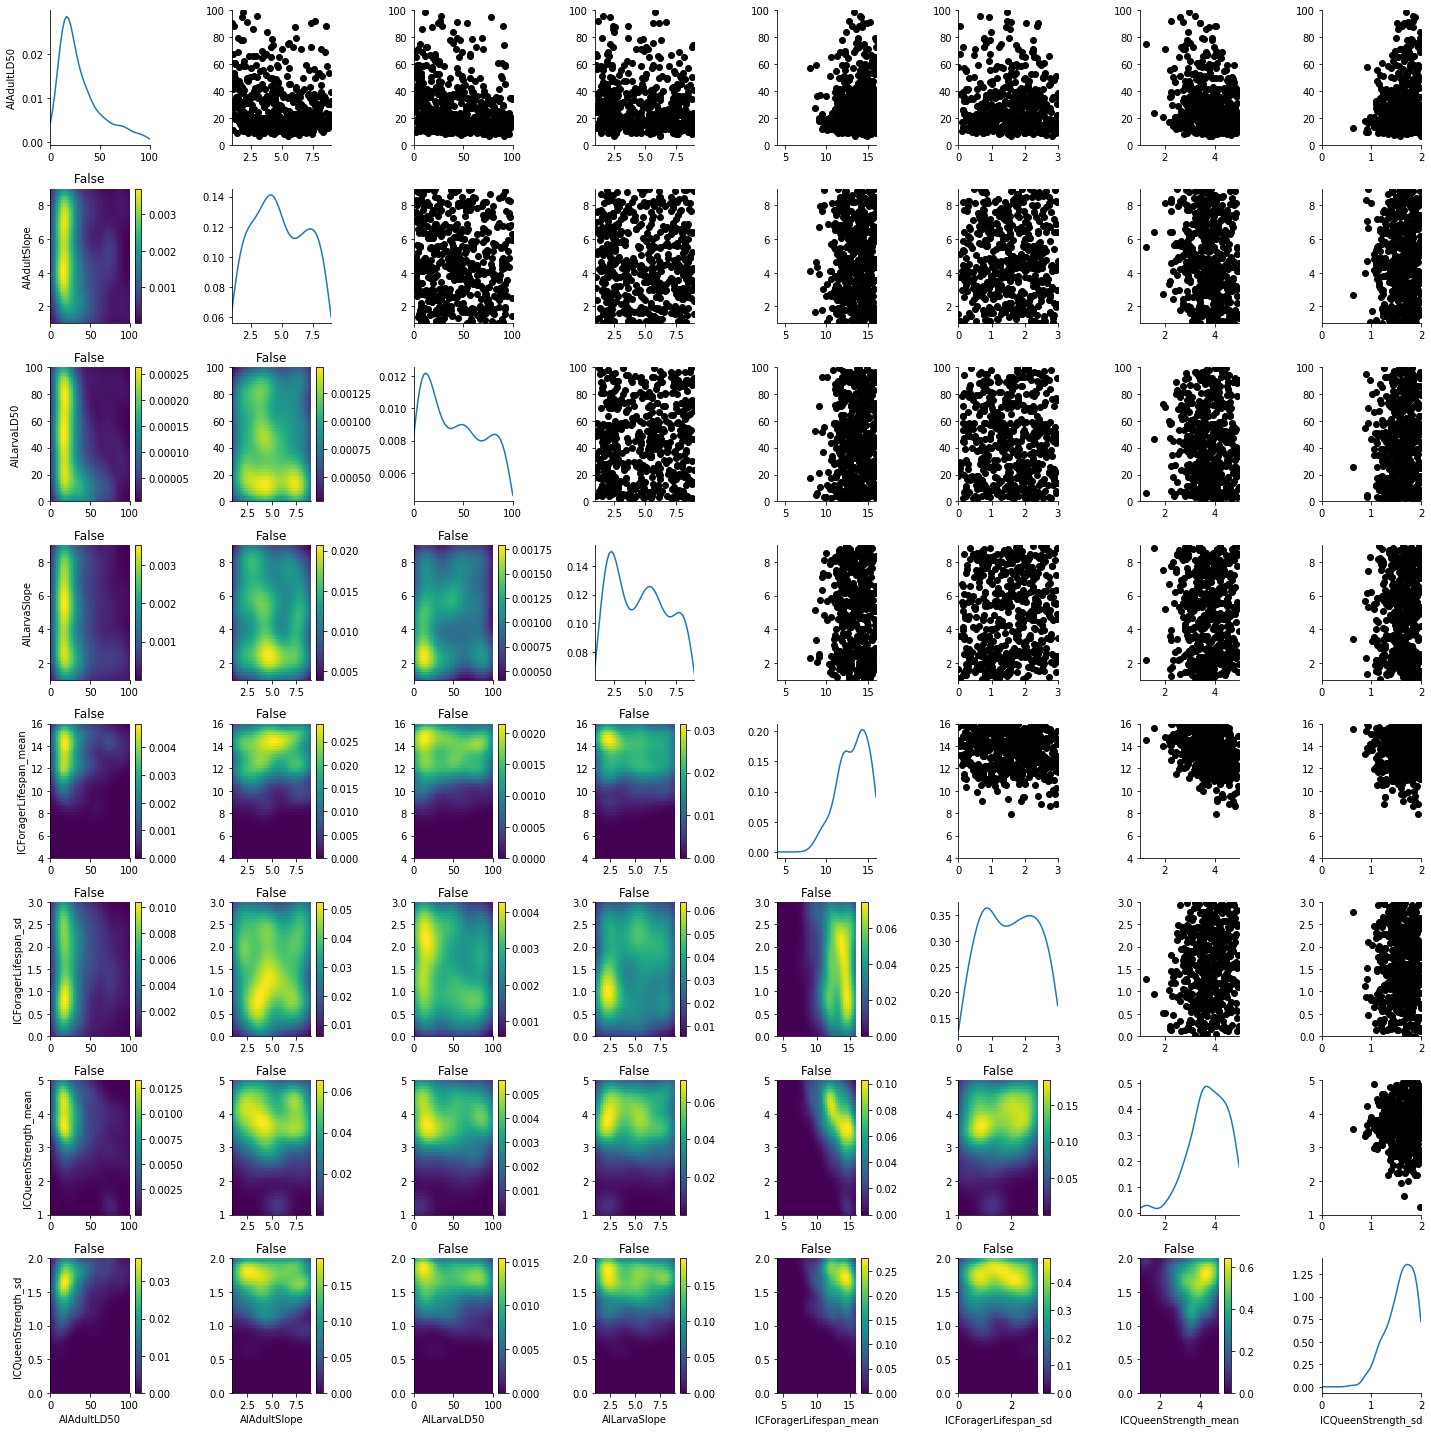

In [33]:
plot_kde_matrix(df, w, limits=limits);

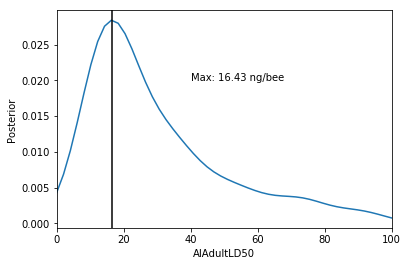

In [28]:
### Show LD50 parameters in linear space
### To consider - the MAP estimate varies depending on if its calculated from the log-space posterior or a linear transformed one

variable = 'AIAdultLD50'
fig, ax = plt.subplots()
df, w = history.get_distribution(m=0, t=history.max_t)
df[[variable]] = df[[variable]].copy()*1000 #unlog transform and convert go ng/bee
pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=100,
                                x=variable, ax=ax)
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.annotate('Max: {:.2f} ng/bee'.format(MAP.item()), xy = (40,0.020))
#plt.savefig("figures/run2_g11_AdultLD50_linear.png")
plt.show()

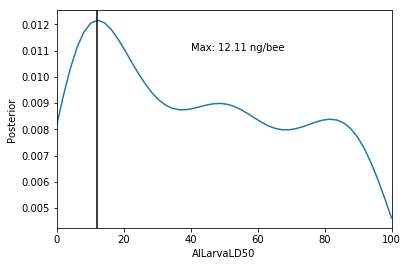

In [29]:
variable = 'AILarvaLD50'
fig, ax = plt.subplots()
df, w = history.get_distribution(m=0, t=history.max_t)
df[[variable]] = df[[variable]].copy() * 1000 #unlog transform and convert go ng/bee
pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=100,
                                x=variable, ax=ax)
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.annotate('Max: {:.2f} ng/bee'.format(MAP.item()), xy = (40,0.011))
#plt.savefig("figures/run2_g11_LarvaLD50_linear.png")
plt.show()

### Calculate LD50 max a posteriori estimate and  95% PIs

These values vary some depending on whether we do KDE on our log-transformed posterior samples or un-logged posterior samples

With log transformed:

In [35]:
#get the maximum a posteriori estimation for AdultLD50
df, w = history.get_distribution(m=0, t=history.max_t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
adult_ld50_map = (MAP.item()) 

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
adult_ld50_median = (x.item(np.min(np.where(cdf > .5)))) 
print('Adult LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(adult_ld50_map, adult_ld50_median))

# calculate 95% credible interval
adult_ld50_lower = (x.item(np.min(np.where(cdf > .025))))
adult_ld50_upper = (x.item(np.min(np.where(cdf > .975))))
print("95% CI: {:.2f} - {:.2f}".format(adult_ld50_lower, adult_ld50_upper))
print("")

#get the maximum a posteriori estimation for LarvaLD50
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
larva_ld50_map = (MAP.item()) 

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
larva_ld50_median = (x.item(np.min(np.where(cdf > .5))))
print('Larva LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(larva_ld50_map, larva_ld50_median))

# calculate 95% credible interval
larva_ld50_lower = (x.item(np.min(np.where(cdf > .025))))
larva_ld50_upper = (x.item(np.min(np.where(cdf > .975))))
print("95% CI: {:.2f} - {:.2f}".format(larva_ld50_lower, larva_ld50_upper))

Adult LD50 MAP: 16.43 ng/bee, median: 25.19 ng/bee
95% CI: 8.13 - 85.12

Larva LD50 MAP: 12.11 ng/bee, median: 44.55 ng/bee
95% CI: 3.75 - 95.67


In [36]:
## Define convenience functions for characterizing marginal distributions

def get_ci(variable, df, w, interval = 95):
    """
    Extract 95% credible intervals for a single parameter weighted posterior samples
    """
    x, pdf = kde_1d(df,w,variable, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    lower = (x.item(np.min(np.where(cdf > .025))))
    upper = (x.item(np.min(np.where(cdf > .975))))
    return lower, upper

def get_MAP(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    MAP = x[np.where(np.max(pdf)==pdf)]
    return MAP.item()

def get_mean(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    mean = np.average(x, weights=pdf)
    return mean

def get_sd(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    sd = np.sqrt(np.cov(x, aweights=pdf))
    return sd
    
def get_median(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    median = (x.item(np.min(np.where(cdf > .5))))
    return median

def describe_marginal(variable, df, w, units = None):
    lower, upper = get_ci(variable, df, w)
    sd = get_sd(variable, df, w)
    MAP = get_MAP(variable, df, w)
    mean = get_mean(variable, df, w)
    median = get_median(variable, df, w)
    unit_str = ""
    if units:
        unit_str = units
    print("Descriptive statistics for {}:".format(variable))
    print("Mean: {:.2f} {}".format(mean, unit_str))
    print("SD: {:.2f} {}".format(sd, unit_str))
    print("Median {:.2f} {}".format(median, unit_str))
    print("MAP: {:.2f} {}".format(MAP, unit_str))
    print("95% CI: {:.2f} - {:.2f} {}".format(lower, upper, unit_str))
    

In [37]:
describe_marginal("AIAdultLD50", df, w, units = "ng/bee")
print()
describe_marginal("AIAdultSlope", df, w)
print()
describe_marginal("AILarvaLD50", df, w, units = "ng/bee")
print()
describe_marginal("AILarvaSlope", df, w)
print()
describe_marginal("ICQueenStrength_mean", df, w)
print()
describe_marginal("ICForagerLifespan_mean", df, w, units = "days")



Descriptive statistics for AIAdultLD50:
Mean: 31.66 ng/bee
SD: 20.61 ng/bee
Median 25.19 ng/bee
MAP: 16.43 ng/bee
95% CI: 8.13 - 85.12 ng/bee

Descriptive statistics for AIAdultSlope:
Mean: 4.93 
SD: 2.18 
Median 4.81 
MAP: 4.13 
95% CI: 1.28 - 8.66 

Descriptive statistics for AILarvaLD50:
Mean: 46.41 ng/bee
SD: 28.24 ng/bee
Median 44.55 ng/bee
MAP: 12.11 ng/bee
95% CI: 3.75 - 95.67 ng/bee

Descriptive statistics for AILarvaSlope:
Mean: 4.82 
SD: 2.24 
Median 4.76 
MAP: 2.30 
95% CI: 1.30 - 8.70 

Descriptive statistics for ICQueenStrength_mean:
Mean: 3.74 
SD: 0.73 
Median 3.79 
MAP: 3.67 
95% CI: 2.14 - 4.88 

Descriptive statistics for ICForagerLifespan_mean:
Mean: 13.07 days
SD: 1.79 days
Median 13.25 days
MAP: 14.34 days
95% CI: 9.18 - 15.79 days


### Draw from posterior to predict dose-response curve for adults

We can draw from our last generation of particles, with probabilty proportional to their weights, to sample the posterior.
Draws of ld50 and slope can be combined to plot dose-response curves.

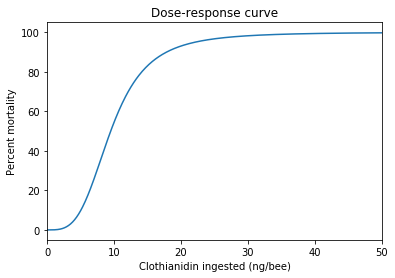

In [41]:
def draw_posterior(df, w, n=1):
    indices = df.index
    draws = random.choices(population=indices, weights = w, k=n)
    return df.loc[draws,:]

def plot_dose_response(ld50, slope, xlim=100, max_dose=100, title='Dose-response curve' ):
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50/x)**slope) #four parameters Hill equation, equal to what VarroaPop uses
    fix, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    plt.show()
 
random.seed(1251)
sample = draw_posterior(df, w, 1)

#Plot a single curve
sample_ld50 = sample.iloc[0,0]
sample_slope = sample.iloc[0,1]
#print("LD50: {}, Slope: {}".format(sample_ld50, sample_slope))
plot_dose_response(sample_ld50, sample_slope, xlim=50)

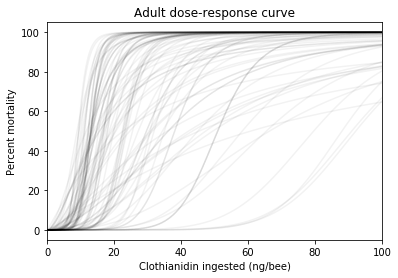

In [44]:
### Plot many curves together

def plot_all_dr(sample, xlim=100, max_dose=100, adult=True, title='Dose-response curve',):
    fix, ax = plt.subplots()
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    ld50_col, slope_col = 0, 1
    if not adult:
        ld50_col, slope_col = ld50_col+2, slope_col+2
    for index, row in sample.iterrows():
        ld50 = row[ld50_col]
        slope = row[slope_col]
        y = 100/(1+(ld50/x)**slope) #four parameters Hill equation
        ax.plot(x, y, 'k',alpha=0.05)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    plt.show()
    
random.seed(1251)
sample = draw_posterior(df, w, 100)

plot_all_dr(sample, xlim=100, title="Adult dose-response curve")

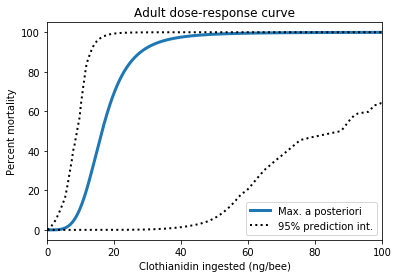

In [45]:
### Plot MAP and 95% Prediction interval

def get_prediction_interval(sample_in, percent=95, max_dose=100, adult=True):
    """
    Get PIs for dose-response curve. 
    Function that takes a set of samples of the posterior (as a input) and returns
    the lower and upper perdiction intervals as 1d arrays.
    """
    sample = sample_in.reset_index(drop=True)
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = np.empty([len(sample.index),x.size])
    if adult:
        for index, row in sample.iterrows():
            ld50 = row[0]
            slope = row[1]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    else:
        for index, row in sample.iterrows():
            ld50 = row[2]
            slope = row[3]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    lower = np.percentile(y,q=(100-percent)/2, axis=0)
    upper = np.percentile(y, q=100-((100-percent)/2), axis=0)
    return lower, upper


def plot_dr_map(df, adult=True, xlim=100, ci=True, percent = 95, sample_num=500, title="Dose-response curve"):
    """
    Plot the dose-response curve for a posterior based on maximum a posteriori values.
    Can also include prediction intervals, which are based on weighted random sampling of the particles. 
    """
    if adult:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AIAdultLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AIAdultSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    else:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AILarvaLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AILarvaSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    sample = draw_posterior(df, w, sample_num)
    lower, upper = get_prediction_interval(sample, max_dose=xlim, adult=adult)
    fix, ax = plt.subplots()
    x = np.linspace(0,xlim, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50_MAP/x)**slope_MAP) #four parameters Hill equation, equal to what VarroaPop uses
    ax.plot(x, y, linewidth=3, label="Max. a posteriori")
    ax.plot(x,lower, 'k', linestyle=":", linewidth=2, label="95% prediction int.")
    ax.plot(x,upper, 'k', linestyle=":", linewidth=2)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    ax.legend()
    plt.show()

#for adults
random.seed(1251)
plot_dr_map(df, percent=95, xlim=100, title = "Adult dose-response curve")

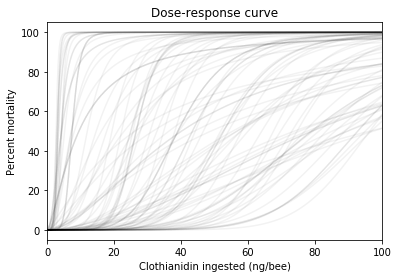

In [46]:
# Multi line plot for larvae
random.seed(1251)
sample = draw_posterior(df, w, 100)

plot_all_dr(sample, xlim=100, adult=False)

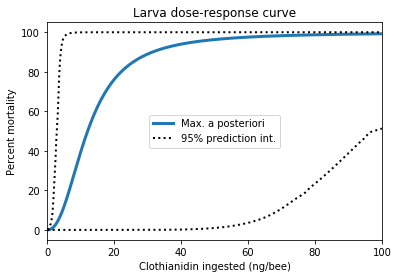

In [47]:
# MAP and PI plot for larvae
random.seed(1251)
plot_dr_map(df, percent=95, adult=False, title = "Larva dose-response curve")

### Draw from the posterior to predict colony-level queen strength and forager lifespan

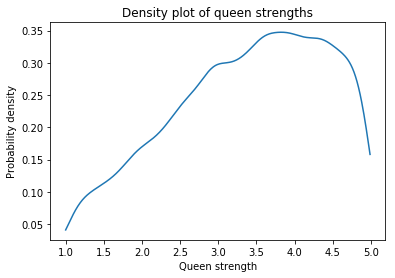

In [48]:
def plot_queenstrength(sample_in, mean_col = 6, sd_col = 7, title='Density plot of queen strengths',):
    sample = sample_in.reset_index(drop=True)
    lower = 1
    upper = 5
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)#draw our 84 study hives
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .01)
    ax.plot(x, density(x)) #for a density plot
    #ax.hist(values_flat) #for a histogram
    ax.set(xlabel='Queen strength', ylabel='Probability density', title=title)
    plt.show()

random.seed(1251)
sample = draw_posterior(df,w,200)
plot_queenstrength(sample)

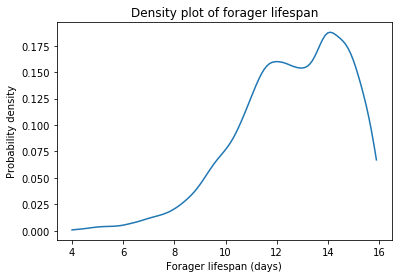

In [49]:
def plot_foragerlifespan(sample_in, mean_col = 4, sd_col=5, title='Density plot of forager lifespan',):
    sample = sample_in.reset_index(drop=True)
    lower = 4
    upper = 16
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)#draw our 84 study hives
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .1)
    ax.plot(x, density(x)) #for a density plot
    #ax.hist(values_flat) #for a histogram
    ax.set(xlabel='Forager lifespan (days)', ylabel='Probability density', title=title)
    plt.show()
    
random.seed(1251)
sample = draw_posterior(df,w,200)
plot_foragerlifespan(sample)

## Let's compare queen strength and forager lifespan fit to all treatments versus just the control

In [13]:
# Load posterior for control only
t_ctrl = history_ctrl.max_t
df_ctrl, w_ctrl = history_ctrl.get_distribution(m=0, t=t_ctrl)

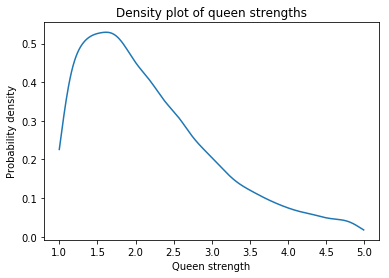

In [14]:
random.seed(1251)
sample = draw_posterior(df_ctrl,w_ctrl,200)
plot_queenstrength(sample, mean_col = 2, sd_col = 3)

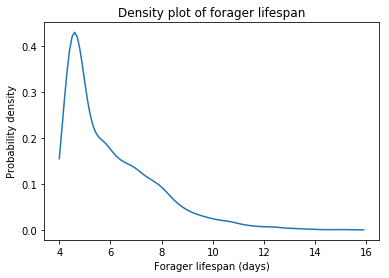

In [15]:
random.seed(1251)
sample = draw_posterior(df_ctrl,w_ctrl,200)
plot_foragerlifespan(sample, mean_col = 0, sd_col = 1)

Directly compare probability densities

In [16]:
def compare_plot_forager_lifespan(sample_in, sample_in_ctrl, mean_col = 4, sd_col = 5, mean_col_ctrl = 0, sd_col_ctrl = 1,
                               title='Density plot of forager lifespan',):
    sample = sample_in.reset_index(drop=True)
    sample_ctrl = sample_in_ctrl.reset_index(drop=True)
    lower = 4
    upper = 16
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .01)
    ax.plot(x, density(x), label = "All treatments") #for a density plot
    for index, row in sample_ctrl.iterrows():
        mu = row[mean_col_ctrl]
        sigma = row[sd_col_ctrl]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .01)
    ax.plot(x, density(x), label = "Control treatment") #for a density plot
    ax.set(xlabel='Forager lifespan (days)', ylabel='Probability density', title=title)
    ax.legend()
    plt.show()
    


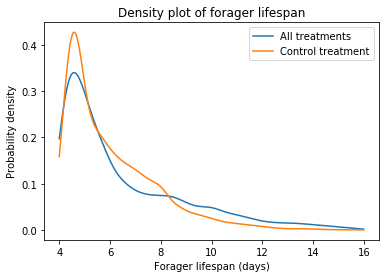

In [17]:
random.seed(1251)
sample = draw_posterior(df,w,200)
random.seed(1251)
sample_ctrl = draw_posterior(df_ctrl,w_ctrl,200)
np.random.seed(885)
compare_plot_forager_lifespan(sample, sample_ctrl)

In [18]:
def compare_plot_queenstrength(sample_in, sample_in_ctrl, mean_col = 6, sd_col = 7, mean_col_ctrl = 2, sd_col_ctrl = 3,
                               title='Density plot of queen strengths',):
    sample = sample_in.reset_index(drop=True)
    sample_ctrl = sample_in_ctrl.reset_index(drop=True)
    lower = 1
    upper = 5
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .01)
    ax.plot(x, density(x), label = "All treatments") #for a density plot
    for index, row in sample_ctrl.iterrows():
        mu = row[mean_col_ctrl]
        sigma = row[sd_col_ctrl]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .01)
    ax.plot(x, density(x), label = "Control treatment") #for a density plot
    ax.set(xlabel='Queen strength', ylabel='Probability density', title=title)
    ax.legend()
    plt.show()
    


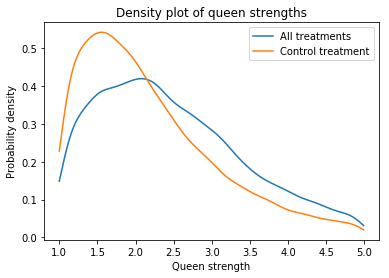

In [19]:
random.seed(1251)
sample = draw_posterior(df,w,200)
random.seed(1251)
sample_ctrl = draw_posterior(df_ctrl,w_ctrl,200)
np.random.seed(885)
compare_plot_queenstrength(sample, sample_ctrl)

Converting queen strength to max. egg laying rate

In [20]:
def convert_qs_egglaying(queen_str):
    egg_rate = (1000*(5-queen_str)+3000*(queen_str-1))/(5-1)
    return egg_rate

def compare_plot_egglaying(sample_in, sample_in_ctrl, mean_col = 6, sd_col = 7, mean_col_ctrl = 2, sd_col_ctrl = 3,
                               title='Density plot of queen egg laying rate',):
    sample = sample_in.reset_index(drop=True)
    sample_ctrl = sample_in_ctrl.reset_index(drop=True)
    lower = 1
    upper = 5
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)
    values_flat = values.flatten()
    values_flat_eggs = convert_qs_egglaying(values_flat)
    lower_eggs, upper_eggs = 1000, 3000
    density = st.kde.gaussian_kde(values_flat_eggs)
    x = np.arange(lower_eggs, upper_eggs, 10)
    ax.plot(x, density(x), label = "All treatments") #for a density plot
    for index, row in sample_ctrl.iterrows():
        mu = row[mean_col_ctrl]
        sigma = row[sd_col_ctrl]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)
    values_flat = values.flatten()
    values_flat_eggs = convert_qs_egglaying(values_flat)
    lower_eggs, upper_eggs = 1000, 3000
    density = st.kde.gaussian_kde(values_flat_eggs)
    x = np.arange(lower_eggs, upper_eggs, 10)
    ax.plot(x, density(x), label = "Control treatment") #for a density plot
    ax.set(xlabel='Max egg laying rate (eggs/day)', ylabel='Probability density', title=title)
    ax.legend()
    plt.show()

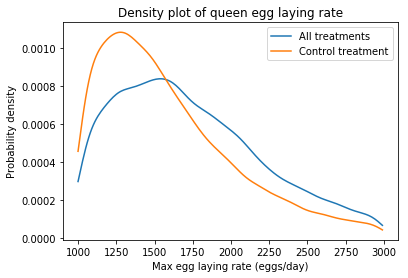

In [21]:
random.seed(1251)
sample = draw_posterior(df,w,200)
random.seed(1251)
sample_ctrl = draw_posterior(df_ctrl,w_ctrl,200)
np.random.seed(885)
compare_plot_egglaying(sample, sample_ctrl)

### How well does our model predict the feeding study results?

In [22]:
# Pull out our MAP parameters and run it in VarroaPop
df_ug, w = history.get_distribution(m=0, t=history.max_t) #get distribution ld50 in ug/bee
MAP_row = np.where(np.max(w)==w)[0][0]
MAP_pars= df_ug.iloc[MAP_row,:].to_dict()
MAP_sim_STATIC = simulate_all_dates(MAP_pars)

D:\Git_files\bee_neonic_abc\tools\DataSimulator.py:130: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  response_df = pd.DataFrame.from_items(zip(col_names,responses))


In [179]:
import matplotlib.dates as mdates
import datetime

def posterior_predict_ci(sample_in, ci = 95):
    predictions = np.empty([6,123,len(sample_in.index),4]) # trt x days x sample x response
    sample_dict = sample_in.reset_index(drop=True).to_dict("index")
    vp_inputs = dict()
    for i, (key, pars) in enumerate(sample_dict.items()):
        output = simulate_all_dates(sample_dict[key])
        for j, resp in enumerate(["Adults", "Pupae", "Larvae", "Eggs"]):
            predictions[:,:,i,j] = output[resp]
    upper = np.percentile(predictions, 100-(100-ci)/2, axis=2)
    lower = np.percentile(predictions, (100-ci)/2, axis=2)
    return lower, upper

    
def plot_pop_predictions(response, df, field_data, lower, upper, pi=True, save=False, fig_form = 'pdf'):
    """ 
    Takes the posterior generation of parameters and 
    plots MAP and 95% PI colony size vs field data
    """
    resp_index = ["Adults", "Pupae", "Larvae", "Eggs"].index(response)
    DATES_STR = ['07/16/2014', '08/08/2014','09/10/2014', '10/15/2014']
    DATES_STR_HIGH = ['07/16/2014', '08/08/2014','09/10/2014', '10/21/2014'] #high had a late CCA7
    initial_df = pd.read_csv('data/initial_conditions.csv', index_col=0)
    #sample = draw_posterior(df,w,samples)
    MAP_row = np.where(np.max(w)==w)[0][0]
    MAP_pars = df.iloc[MAP_row,:].to_dict()
    #MAP_sim = simulate_all_dates(MAP_pars)
    MAP_sim = MAP_sim_STATIC[response] #this was calculated outside the function
    fig, axs = plt.subplots(2, 3, figsize=(9,6),sharex=False, sharey=True)
    axs = axs.ravel()
    trts = ["0", "10", "20", "40", "80", "160"]
    start = datetime.datetime.strptime('06/20/2014', "%m/%d/%Y")
    end = datetime.datetime.strptime('10/21/2014', "%m/%d/%Y")
    date_range = [(start + datetime.timedelta(days=x)) for x in range(0, (end - start).days)]
    days = mdates.DayLocator([10,20])   # every year
    months = mdates.MonthLocator()  # every month
    monthsFmt = mdates.DateFormatter('%B')
    for i, trt in enumerate(trts):
        axs[i].plot(date_range, MAP_sim.iloc[i,:], linewidth=3, label="Most probable")
        if trt == "160":
            field_dates = [datetime.datetime.strptime(date, "%m/%d/%Y").date() for date in DATES_STR_HIGH]
        else:
            field_dates = [datetime.datetime.strptime(date, "%m/%d/%Y").date() for date in DATES_STR]
        if pi:
            axs[i].plot(date_range,lower[i,:,resp_index], 'k', linestyle=":", linewidth=2, label="95% PI")
            axs[i].plot(date_range,upper[i,:, resp_index], 'k', linestyle=":", linewidth=2)
        empirical_pops = np.append(initial_df.loc[int(trt),response.lower()+"_mean"],
                                   field_data["mean"][i,:,resp_index]) #append start date to otherdates
        empirical_sd = np.append(initial_df.loc[int(trt),response.lower()+"_sd"],
                                 field_data["sd"][i,:,resp_index]) #append start date to otherdates
        #axs[i].plot_date([start]+field_dates, empirical_pops, label= "Feeding study data")
        axs[i].errorbar([start]+field_dates, empirical_pops, yerr = empirical_sd, fmt='o',
                        color = 'tab:orange', label = "Feeding study data")
        axs[i].set_title(trt+" ppb clothianidin")
        axs[i].xaxis.set_major_locator(months)
        axs[i].xaxis.set_major_formatter(monthsFmt)
        axs[i].xaxis.set_minor_locator(days)
        axs[i].set_ylim(bottom=0)
        if i in [0,3]:
            axs[i].set(ylabel=response + " per colony")
    handles, labels = axs[i].get_legend_handles_labels()
    fig.autofmt_xdate()
    fig.tight_layout()
    lgd = plt.legend(handles,labels, loc='center left', bbox_to_anchor=(1, 1), prop={'size': 12})
    if save:
        plt.savefig('figures/posterior_predictions/bee_population/{}.{}'.format(response, fig_form),
                    bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    
def convert_data_dict(data_dict):
    """
    Convert the dictionary of study populations by trt and time
    into a 3d array (treatment x time x response var)
    """
    out = {}
    for stat in ["mean", "sd"]:
        out_stat = np.empty([6, 4, 4])
        for h, h_str in enumerate(["Adults", "Pupae", "Larvae", "Eggs"]):
            for i, i_str in enumerate(["0", "10", "20", "40", "80", "160"]):
                for j, j_str in enumerate(["4", "5", "6", "7"]):
                    key = i_str+"_"+j_str+"_{}_{}".format(h_str, stat)
                    out_stat[i,j,h] = data_dict[key]
        out[stat] = out_stat
    return out

In [ ]:
field_data = convert_data_dict(study_data_all)
df_ug, w = history.get_distribution(m=0, t=history.max_t) #get distribution ld50 in ug/bee
random.seed(1251)
sample = draw_posterior(df_ug,w,200)
lower_pi, upper_pi = posterior_predict_ci(sample)

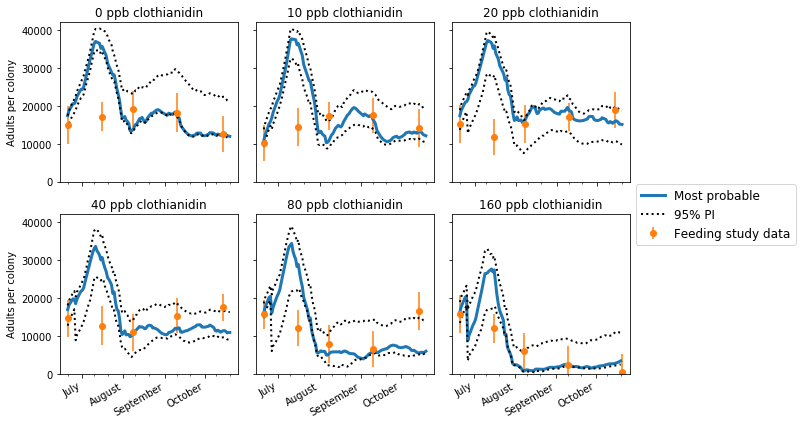

In [185]:
plot_pop_predictions('Adults', df_ug, field_data, lower=lower_pi, upper=upper_pi, save = True, fig_form='pdf')

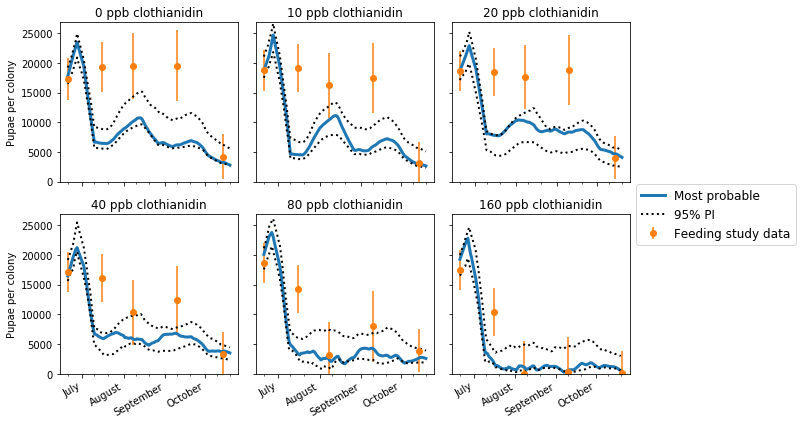

In [186]:
plot_pop_predictions('Pupae', df_ug, field_data, lower=lower_pi, upper=upper_pi, save = True, fig_form='pdf')

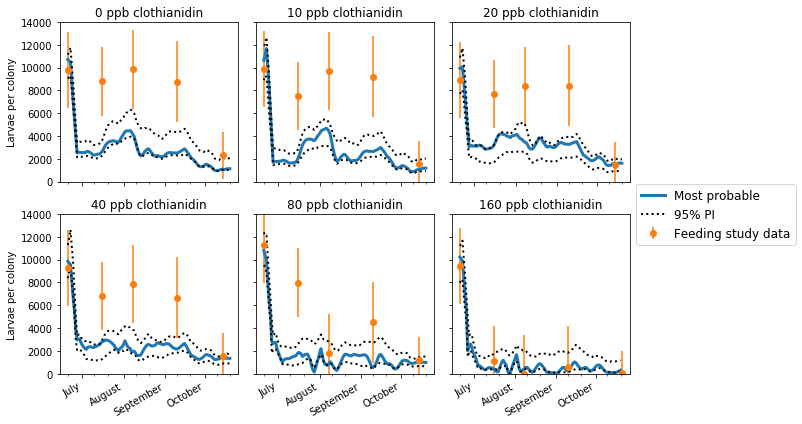

In [187]:
plot_pop_predictions('Larvae', df_ug, field_data, lower=lower_pi, upper=upper_pi, save = True, fig_form='pdf')

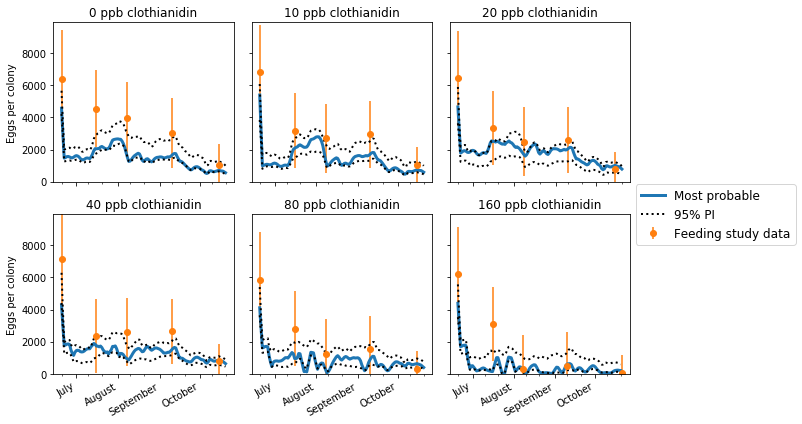

In [188]:
#field_data = convert_data_dict(study_data_all)
plot_pop_predictions('Eggs', df_ug, field_data, lower=lower_pi, upper=upper_pi, save = True, fig_form='pdf')

In [189]:
#sample = draw_posterior(df,w,2)
#posteriobr_predict_ci(sample)